# Fraud Detection with Pytorch Geometric

## Installation

In [1]:
# Install required packages.
import os
import torch

os.environ["TORCH"] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0


c:\Users\leok8\miniconda3\envs\net-sci\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.utils import to_networkx
from src.model import GNN, GNNWithAttentionFusion

## Dataset

- Contains news propagation graphs extracted from Twitter
- Source and raw data: https://github.com/KaiDMML/FakeNewsNet
- Preprocessing: https://arxiv.org/pdf/2104.12259.pdf
- feature="content" --> Spacy Word2Vec + Profile features


In [4]:
from torch_geometric.datasets import UPFD

train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Train Samples:  1092
Test Samples:  3826


### Investigating the News Propagation Graph

In [5]:
sample_id = 1
train_data[sample_id].x.shape

torch.Size([125, 310])

In [6]:
train_data[sample_id].y.shape

torch.Size([1])

In [7]:
train_data[sample_id].x

tensor([[0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529],
        [0.4610, 0.4544, 0.6279,  ..., 0.2055, 0.1667, 0.2500],
        [0.4461, 0.4728, 0.4978,  ..., 0.8356, 0.0556, 0.0000],
        ...,
        [0.5574, 0.4934, 0.5588,  ..., 0.3562, 0.0556, 0.2647],
        [0.5274, 0.5889, 0.4425,  ..., 0.9589, 0.1111, 0.1176],
        [0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529]])

In [8]:
train_data[sample_id].edge_index.t()

tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        [  0,   4],
        [  0,   5],
        [  0,   6],
        [  0,   7],
        [  0,   8],
        [  0,   9],
        [  0,  10],
        [  0,  11],
        [  0,  12],
        [  0,  13],
        [  0,  14],
        [  0,  15],
        [  0,  16],
        [  0,  17],
        [  0,  18],
        [  0,  19],
        [  0,  20],
        [  0,  21],
        [  0,  22],
        [  0,  23],
        [  0,  24],
        [  0,  25],
        [  0,  26],
        [  0,  27],
        [  0,  28],
        [  0,  29],
        [  0,  30],
        [  0,  31],
        [  0,  32],
        [  0,  33],
        [  0,  34],
        [  0,  35],
        [  0,  36],
        [  0,  37],
        [  0,  38],
        [ 15,  39],
        [ 15,  40],
        [ 17,  43],
        [ 17,  44],
        [ 22,  45],
        [ 22,  46],
        [ 22,  47],
        [ 22,  48],
        [ 23,  49],
        [ 26,  50],
        [ 26,  51],
        [ 26,  52],


In [9]:
for data in train_data:
    print(data.y)

tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tens

In [10]:
import networkx as nx

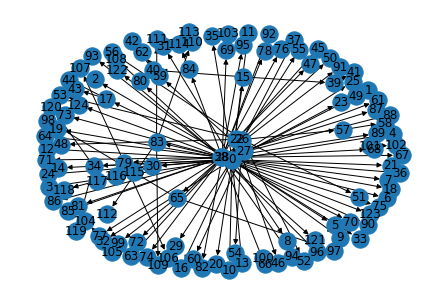

In [11]:
nx.draw(to_networkx(train_data[sample_id]), with_labels=True)

### Node features

In [12]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([125, 310])


tensor([[0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529],
        [0.4610, 0.4544, 0.6279,  ..., 0.2055, 0.1667, 0.2500],
        [0.4461, 0.4728, 0.4978,  ..., 0.8356, 0.0556, 0.0000],
        ...,
        [0.5574, 0.4934, 0.5588,  ..., 0.3562, 0.0556, 0.2647],
        [0.5274, 0.5889, 0.4425,  ..., 0.9589, 0.1111, 0.1176],
        [0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529]])

### Class distribution

<AxesSubplot:>

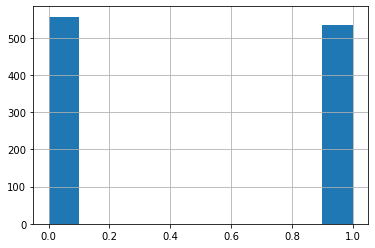

In [13]:
import pandas as pd

labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

### Data Loaders

In [14]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

## Model and Training

--> Because it is a directed graph, it will only share information from the root

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda


In [38]:
from src.trainer import Trainer

model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

trainer = Trainer(model, loss_func=loss_fnc, optimizer=optimizer, device=device)

train_losses_concat_lr_2e_4 = []
test_losses_concat_lr_2e_4 = []
test_acces_concat_lr_2e_4 = []
test_f1score_concat_lr_2e_4 = []

for epoch in range(60):
    train_loss = trainer.train(train_loader)
    test_loss, test_acc, test_f1 = trainer.test(test_loader)

    train_losses_concat_lr_2e_4.append(train_loss)
    test_losses_concat_lr_2e_4.append(test_loss)
    test_acces_concat_lr_2e_4.append(test_acc)
    test_f1score_concat_lr_2e_4.append(test_f1)

    print(
        f"Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | "
        f"TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}"
    )

Epoch: 00 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.54 | TestF1: 0.16
Epoch: 03 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 04 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.73 | TestF1: 0.64
Epoch: 05 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.84 | TestF1: 0.82
Epoch: 07 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.68 | TestF1: 0.53
Epoch: 08 |  TrainLoss: 0.68 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 09 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 10 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.76 | TestF1: 0.80
Epoch: 11 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.61 | TestF1: 0.35
Epoch: 12 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.73 | TestF1: 0.78

In [26]:
for data in test_loader:
    data = data.to(device)
    pred = trainer.model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.cpu().detach().numpy()[:, 0]
    df["pred"] = torch.round(pred).cpu().detach().numpy()[:, 0]
    df["true"] = data.y.cpu().numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.576764   1.0     1
1    0.503087   1.0     1
2    0.430423   0.0     0
3    0.512809   1.0     1
4    0.339395   0.0     0
5    0.436462   0.0     0
6    0.420225   0.0     0
7    0.617786   1.0     1
8    0.338772   0.0     0
9    0.413669   0.0     0


In [28]:
model_2 = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

trainer_2 = Trainer(
    model=model_2, loss_func=loss_fnc, optimizer=optimizer, device=device
)

train_losses_concat_lr_1e_2 = []
test_losses_concat_lr_1e_2 = []
test_acces_concat_lr_1e_2 = []
test_f1score_concat_lr_1e_2 = []

for epoch in range(60):
    train_loss = trainer_2.train(train_loader)
    test_loss, test_acc, test_f1 = trainer_2.test(test_loader)

    train_losses_concat_lr_1e_2.append(train_loss)
    test_losses_concat_lr_1e_2.append(test_loss)
    test_acces_concat_lr_1e_2.append(test_acc)
    test_f1score_concat_lr_1e_2.append(test_acc)

    print(
        f"Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | "
        f"TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}"
    )

Epoch: 00 |  TrainLoss: 0.75 | TestLoss: 0.70 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.69 | TestLoss: 0.71 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.69 | TestLoss: 0.76 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 03 |  TrainLoss: 0.72 | TestLoss: 0.70 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 04 |  TrainLoss: 0.70 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 05 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.70 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 07 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 08 |  TrainLoss: 0.68 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 09 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 10 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.66 | TestLoss: 0.66 | TestAcc: 0.57 | TestF1: 0.25
Epoch: 12 |  TrainLoss: 0.66 | TestLoss: 0.66 | TestAcc: 0.50 | TestF1: 0.67

In [29]:
fusion_model = GNNWithAttentionFusion(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.0002, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

trainer_attention_fusion = Trainer(
    model=fusion_model, loss_func=loss_fnc, optimizer=optimizer, device=device
)

train_losses_fusion = []
test_losses_fusion = []
test_acces_fusion = []
test_f1score_fusion = []

for epoch in range(60):
    train_loss = trainer_attention_fusion.train(train_loader)
    test_loss, test_acc, test_f1 = trainer_attention_fusion.test(test_loader)

    train_losses_fusion.append(train_loss)
    test_losses_fusion.append(test_loss)
    test_acces_fusion.append(test_acc)
    test_f1score_fusion.append(test_f1)

    print(
        f"Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | "
        f"TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}"
    )

Epoch: 00 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 03 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 04 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 05 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 07 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 08 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 09 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 10 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 12 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.85 | TestF1: 0.86

## Results

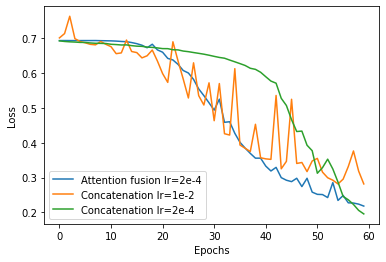

In [39]:
import matplotlib.pyplot as plt

plt.plot(test_losses_fusion, label="Attention fusion lr=2e-4")
plt.plot(test_losses_concat_lr_1e_2, label="Concatenation lr=1e-2")
plt.plot(test_losses_concat_lr_2e_4, label="Concatenation lr=2e-4")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

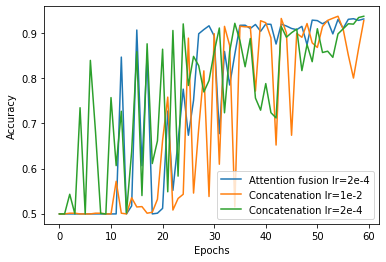

In [40]:
plt.plot(test_acces_fusion, label="Attention fusion lr=2e-4")
plt.plot(test_acces_concat_lr_1e_2, label="Concatenation lr=1e-2")
plt.plot(test_acces_concat_lr_2e_4, label="Concatenation lr=2e-4")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

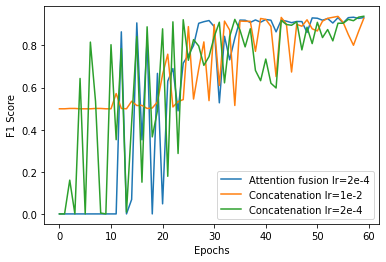

In [41]:
plt.plot(test_f1score_fusion, label="Attention fusion lr=2e-4")
plt.plot(test_f1score_concat_lr_1e_2, label="Concatenation lr=1e-2")
plt.plot(test_f1score_concat_lr_2e_4, label="Concatenation lr=2e-4")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Visualization with T-SNE

In [43]:
from sklearn.manifold import TSNE
import numpy as np

In [44]:
# a parameter for dimension reduction
n_components = 2

## Concatenation (lr=0.0002)

c:\Users\leok8\miniconda3\envs\net-sci\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


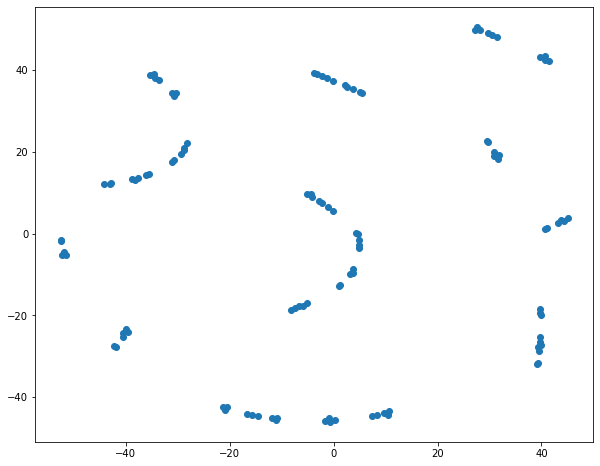

In [45]:
# load the node embedding vector that has been trained. (34, 4) dimension
node_emb = np.copy(model.emb.cpu().detach().numpy())

# transform the node embedding vector size from (34, 4) into (34, 2) with a T-SNE model
model_tsne = TSNE(n_components=n_components, learning_rate=100, perplexity=3)
node_emb_2d = model_tsne.fit_transform(node_emb)

# separate the x-axis values and y-axis values
x = node_emb_2d[:, 0]
y = node_emb_2d[:, 1]

# set color options from the labels.
# node_colours = labels[:, -1]

# scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x, y, cmap="jet")
plt.show()

## Concatenation (lr=0.01)

c:\Users\leok8\miniconda3\envs\net-sci\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


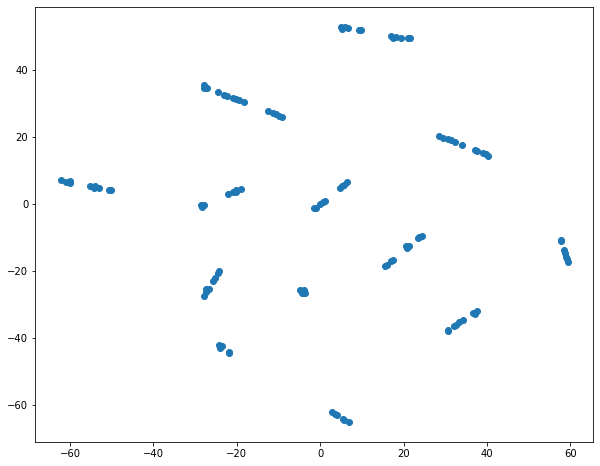

In [46]:
# load the node embedding vector that has been trained. (34, 4) dimension
node_emb = np.copy(model_2.emb.cpu().detach().numpy())

# transform the node embedding vector size from (34, 4) into (34, 2) with a T-SNE model
model_tsne = TSNE(n_components=n_components, learning_rate=100, perplexity=3)
node_emb_2d = model_tsne.fit_transform(node_emb)

# separate the x-axis values and y-axis values
x = node_emb_2d[:, 0]
y = node_emb_2d[:, 1]

# set color options from the labels.
# node_colours = labels[:, -1]

# scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x, y, cmap="jet")
plt.show()

## Attention fusion (lr=0.0002)

c:\Users\leok8\miniconda3\envs\net-sci\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


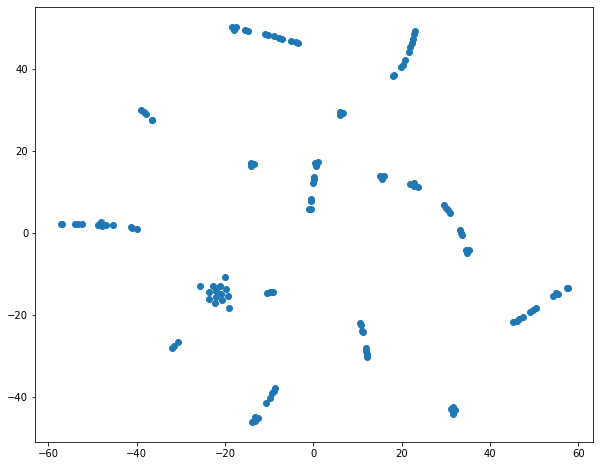

In [47]:
# load the node embedding vector that has been trained. (34, 4) dimension
node_emb = np.copy(fusion_model.emb.cpu().detach().numpy())

# transform the node embedding vector size from (34, 4) into (34, 2) with a T-SNE model
model_tsne = TSNE(n_components=n_components, learning_rate=100, perplexity=3)
node_emb_2d = model_tsne.fit_transform(node_emb)

# separate the x-axis values and y-axis values
x = node_emb_2d[:, 0]
y = node_emb_2d[:, 1]

# set color options from the labels.
# node_colours = labels[:, -1]

# scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x, y, cmap="jet")
plt.show()